# MCI (Multi Cylindrical Image)  Extraction

## main.py

In [49]:
import trimesh
import rtree
import shapely
import random
import time
import os
import multiprocessing
import json

import numpy as np
import cv2
from plyfile import PlyData, PlyElement
import generatePC

In [3]:
# class DataLoader:
#     #============================================================
#     # LoadData Function
#     # Must import 'trimesh'
#     #============================================================
#     def __init__(self, scan_id, data_path='/root/dataset'):
#         self.scan_id = scan_id
#         self.data_path = data_path
        
#         # scene mesh
#         self.ply_name = self.data_path + '/{}/labels.instances.annotated.v2.ply'.format(scan_id)
#         self.mesh = trimesh.load_mesh(self.ply_name)

#         # scene graph
#         with open(self.data_path + '/3RScan_ERP/objects.json') as f:
#             self.objs = json.load(f)[self.scan_id]
#         with open(self.data_path + '/3RScan_ERP/new_relationships.json') as f:
#             self.rels = json.load(f)[self.scan_id]
        
#     def getScanID():
#         return self.scan_id
    
#     def getMesh():
#         return self.mesh
    
#     def getSG():
#         return (self.objs, self.rels)

#     def getPlyName():
#         return self.ply_name

## Classes
* 이후에 main에 추가해서 encapsulation

## Ordering with Distance

In [50]:
# It can be any object, including camera
# import numpy as np

class Obj:
    def __init__(self, pos):
        # Object's position → (min + max)/2
        self.x_pos = pos[0]
        self.y_pos = pos[1]
        self.z_pos = pos[2]

    def getCart(self):
        return (self.x_pos, self.y_pos, self.z_pos)
    
    def getSphere(self):
        return cart2sph(self.x_pos, self.y_pos, self.z_pos)
    
    def getDist(self):
        return self.distance
    
    def getAng(self):
        return self.angle
    
    def setCart(self, x, y, z):
        self.x_pos = x
        self.y_pos = y
        self.z_pos = z
    
    def setDist(self, distance):
        self.distance = distance
    
    def setAng(self, angle):
        self.angle = angle
    
    def setBin(self, bev_bin):
        self.bev_bin = bev_bin
    
    #=========================================================================
    # cart2sph -> cartesian coordinates to sphere coordinates
    # sph2cart -> sphere coordinates to cartesian coordinates
    #=========================================================================
    def cart2sph(self, x, y, z):
        azimuth = np.arctan2(y, x) # theta
        elevation = np.arctan2(z, np.sqrt(x**2 + y**2)) # phi
        r = np.sqrt(x**2 + y**2 + z**2)
        return (r, azimuth, elevation)
    
    def sph2cart(self, r, azimuth, elevation): # r, theta, phi
        x = r * np.cos(elevation) * np.cos(azimuth)
        y = r * np.cos(elevation) * np.sin(azimuth)
        z = r * np.sin(elevation)
        return (x, y, z)

In [51]:
# practice
scan_id = '09582223-e2c2-2de1-94b6-750684b4f80a'
point_cloud = generatePC.get_pc(scan_id)
seg2pc = generatePC.get_seg2pc(scan_id, point_cloud)
obj2pc = generatePC.get_obj2pc(scan_id, seg2pc)

print(len(obj2pc.keys()))

7


In [172]:
# camPos, objPoses를 인스턴스 자체로..?
class BEV:
    #=========================================================================
    # bird-eye-view version of the scene (with the class 'Obj')
    # Args:
    #     camPos : (x_coordinate, y_coordinate, z_coordinate) of Camera
    #     objPoses : dictionary datatype
    #         key : object id
    #         value : list of coordinates of the object's center
    #=========================================================================
    def __init__(self, camPos, objPoses):
        self.cam = Obj(camPos) # 'camera' Obj class
        self.objects = [] # list of 'object' Obj classes
        
        for key in objPoses.keys():
            self.objects.append(Obj(objPoses[key]))

        cam_x, cam_y, cam_z = self.cam.getCart()
        
        # Set object's distance and angle
        for i in range(len(objPoses.keys())):
            obj_x, obj_y, obj_z = self.objects[i].getCart()
            self.objects[i].setDist(np.sqrt((obj_x - cam_x) ** 2 + (obj_y - cam_y) ** 2))
            self.objects[i].setAng(np.arctan2(obj_y - cam_y, obj_x - cam_x))
    
    def Distance(self, obj_index=None):
        #============================================================
        # Get distance (list) of object(s) from camera
        # obj_index : 1, 2, 3, ...
        # if obj_index is None, then the dictionary of distances will be returned.
        #============================================================
        if obj_index == None:
            distances = {}
            for i in range(len(self.objects)):
                distances.update({int(i) : self.objects[i].getDist()})
            return distances
        else:
            index = obj_index - 1
            return self.objects[index].getDist()
    
    def Direction(self, obj_index=None):
        #============================================================
        # Get direction (list) of object(s) from camera
        # obj_index : 1, 2, 3, ...
        # if obj_index is None, then the dictionary of directions will be returned.
        #============================================================
        if obj_index == None:
            angles = {}
            for i in range(len(self.objects)):
                angles.update({int(i) : self.objects[i].getAng()})
            return angles
        else:
            index = obj_index - 1
            return self.objects[index].getAng()
    
    #=========================================================================
    # multi cylindrical image
    # split the distance along the bins in bird eye view
    #=========================================================================
#     def split(self, height, width, obj_distances, num_bin, dstep):
#         print('splitting by distances from the camera...')
#         x = self.obj_x - self.cam_x
#         y = self.obj_y - self.cam_y

#         mci = np.zeros(height, width, num_bin + 1) # 3rd index : bins (0th bin : camera itself)
#         for i in range(len(obj_distances)):
#             if num_bin * dstep < obj_distances[i]: # if the distance value is greater than last bin, project it to the last bin
#                mci[x, y, ] = num_bin * dstep
            
#             else:
#                 diff = obj_distances[i] % dstep
#                 if diff == 0:
#                     splitted_dist[i] = obj_distances[i]
#                 elif diff > dstep / 2:
#                     p = 

In [204]:
def bin_ordering(scan_id):
    #============================================================
    # Ordering by splitting with bins
    # Get scene mesh and scene graph data and gives some ERP
    # You should import 'trimesh', 'plyfile'
    # Args:
    #     scan_id : index of scans (default: all scans → 추후에 추가)
    #     data_path : root directory path of mesh data (.ply) and graph data (.json)
    #     iterations
    #     cam_pos : coordinate of camera
    #     ray_comps : components of ray
    # You should import 'trimesh'
    #============================================================
    start = time.time()
    
    #============================================================
    # Load the data
    #============================================================
    
    # scene mesh
    filename = '/root/dev/3RScan/{}/labels.instances.annotated.v2.ply'.format(scan_id)
    mesh = trimesh.load_mesh(filename)
    
    with open('/root/dev/3DSSG/objects.json', 'r') as ro:
        data_obj = json.load(ro)
    with open('/root/dev/3DSSG/relationships.json', 'r') as rr:
        data_rel = json.load(rr)
    
    for scan in data_obj['scans']:
        if scan_id == scan['scan']:
            objects = scan['objects']
    
    for scan in data_rel['scans']:
        if scan_id == scan['scan']:
            relationships = scan['relationships']
    
    #============================================================
    # Variables
    #============================================================
    # output ERP size
    width = 1024//2
    height = 512//2
    
    # semantic informations
    plydata = PlyData.read(filename)
    faces = plydata['face'].data['vertex_indices']
    vertices = plydata['vertex'].data
    
    # Region to sample a random camera pos
    point_cloud = generatePC.get_pc(scan_id)
    print('point_cloud: ', point_cloud)
    print('shape: ', np.array(point_cloud).shape)
    seg2pc = generatePC.get_seg2pc(scan_id, point_cloud)
    # print('seg2pc: ', seg2pc)
    obj2pc = generatePC.get_obj2pc(scan_id, seg2pc)
    print('obj2pc - keys: ', type(obj2pc.keys()))
    
    min_point = np.min(point_cloud, axis=0)
    max_point = np.max(point_cloud, axis=0)
    
    # floor vertices (object id of floor: 1)
    floor = obj2pc[1]
    
    # directory to save
    save_path = '/root/dev/3DSSG/new_objects.json'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    #============================================================
    # ray casting (cam pos 랜덤 생성하는 부분만 가져옴 -> 나중에 삭제)
    #============================================================
    # get random cam pos until it is on the floor
    floor_global_id = 0
    while floor_global_id != 188: # floor's global_id == 188
        print("==============================================")
        random_idx = random.randint(0, len(floor) - 1)
        cam_x = floor[random_idx][0]
        cam_y = floor[random_idx][1]
        cam_z = (min_point[2] + max_point[2]) / 2
        
        camray_direction = np.array([[0, 0, -1]]) # downward dir
        
        # get global id of the face which intersects first from camera with downward direction ray
        floor_id = mesh.ray.intersects_first(np.array([[cam_x, cam_y, cam_z]]), camray_direction)
        floor_vertex3 = faces[floor_id]
        floor_vertex = vertices[floor_vertex3[0][0]]
        
        floor_global_id = floor_vertex[7]
    
    # print('Cam Pos: ({}, {}, {})'.format(cam_x, cam_y, cam_z))
    
    #=========================================================================
    # get the camera position and objects' positions
    #=========================================================================
    cam = Obj((cam_x, cam_y, cam_z))
    print('Position of camera: ', cam.getCart())
    obj_poses = generatePC.obj_pos(obj2pc)
    objs = {}

    for key in obj2pc.keys():
        objs.update({int(key) : Obj(obj_poses[key])})
        print('Position of {}th object: {}'.format(key, objs[key].getCart()))
    
    #=========================================================================
    # with BEV class
    #=========================================================================
    bev = BEV(cam.getCart(), obj_poses)
    
    # get the distances and directions
    distances = bev.Distance()
    print(distances)
    
    #=========================================================================
    # visualization
    #=========================================================================
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # point cloud (obj2pc)
    pc_x = []
    pc_y = []
    pc_z = []
    for key in obj2pc.keys():
        pc_x.extend(obj2pc[key][:,0])
        pc_y.extend(obj2pc[key][:,1])
        pc_z.extend(obj2pc[key][:,2])
    ax.scatter(pc_x, pc_y, pc_z, c='r', marker='o', s=1)
    
    # camera
    cam_x, cam_y, cam_z = cam.getCart()
    ax.scatter(cam_x, cam_y, cam_z, c='y', marker='s', s=100)
    
    # objects
    obj_x = []
    obj_y = []
    obj_z = []
    
    for key in objs.keys():
        obj_x.extend([objs[key].getCart()[0]])
        obj_y.extend([objs[key].getCart()[1]])
        obj_z.extend([objs[key].getCart()[2]])
    ax.scatter(obj_x, obj_y, obj_z, c='b', marker='o', s=50)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

In [ ]:
def plot_objs(objs, ):
    obj_x = []
    obj_y = []
    obj_z = []
    
    for key in objs.keys():
        obj_x = objs[key].getCart()[0]
        obj_y = objs[key].getCart()[1]
        obj_z = objs[key].getCart()[2]
    ax.scatter(obj_x, obj_y, obj_z, c='b', marker='o', s=50)

point_cloud:  [[ 1.01      1.10645  -0.85    ]
 [ 1.01      1.10237  -0.87    ]
 [ 1.15      1.15831  -0.91    ]
 ...
 [ 0.89      1.05     -0.57428 ]
 [ 0.87      1.05     -0.571346]
 [ 0.87      1.03     -0.573988]]
shape:  (6181, 3)
obj2pc - keys:  <class 'dict_keys'>
Position of camera:  (1.39, 1.21, -0.79563)
Position of 1th object: (0.6031407963314361, 0.39542973695762274, -1.316261998734972)
Position of 2th object: (0.7099786323800292, 0.9738491139117812, -0.9215694139602522)
Position of 6th object: (0.6546973645418316, 0.8066702948207176, -1.0509483585657369)
Position of 3th object: (1.1140565620214415, 0.8447169525267998, -0.8248220857580394)
Position of 8th object: (0.803936597765363, 0.9337689692737432, -0.372452148044693)
Position of 4th object: (0.2613214263085399, 0.5398920606060602, -0.8527443787878792)
Position of 7th object: (-0.8625773065693423, 0.03543752737226275, -1.1536915145985394)
{0: 1.1325511555028558, 1: 0.7198585287540783, 2: 0.8386565547300843, 3: 0.4577952

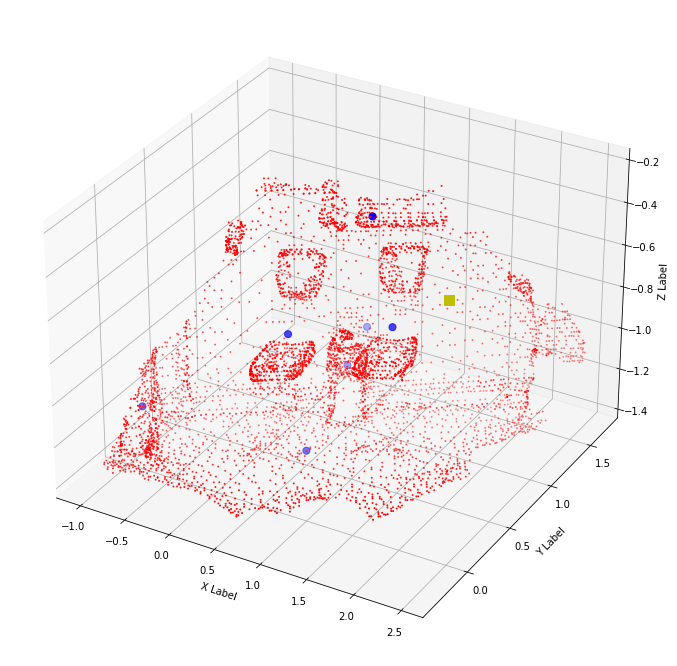

In [205]:
bin_ordering('09582223-e2c2-2de1-94b6-750684b4f80a')

## Creating MSI (by Jongsung)

In [ ]:
def pr_representation(depth, planes, dstep):
    mpis = np.zeros((depth.shape[0], depth.shape[1], planes+2))
    residual = np.zeros((depth.shape[0], depth.shape[1]))
    for i in range(depth.shape[0]):
        for j in range(depth.shape[1]):
            if planes * dstep < depth[i, j]:    # value가 maximum range를 벗어날 때 값들을 마지막 plane으로 투영
                depth[i, j] = planes * dstep
            
            diff = depth[i, j] % dstep
            if diff == 0:   # residual이 0일경우
                mpis[i, j, int(depth[i, j]//dstep)] = depth[i, j]
                residual[i, j] = 0
            
            else:
                # plane, residual 계산하는 부분
                if diff > dstep / 2:
                    p = round(depth[i, j] - diff + dstep, 1)
                    mpis[i, j, int(p/dstep)] = p
                    residual[i, j] = diff - dstep
                else:
                    if depth[i,j] < 0.6:
                        print("asdasdas")
                    p = round(depth[i, j] - diff, 1)
                    mpis[i, j, int(p/dstep)] = p
                    residual[i, j] = diff
    
    residual = (residual + (dstep/2)) / dstep   # residual의 범위를 [0, 1]로 해줌 (-0.5 해서 사용하면 됨)
    mpis[:, :, -1] = residual
    
    # 64 channel data -> 2 channel index data (To prevent Disk I/O Bottleneck)
    idx = np.argmax(mpis, axis=2)
    residual = mpis[:, :, -1]
    idx = np.expand_dims(idx, 2)
    residual = np.expand_dims(residual, 2)
    msi = np.concatenate((idx, residual), axis=2)
    
    return msi

## Visualization with Pymeshlab

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [120]:
# def get_pts(infile):
#     data = np.loadtxt(infile, delimiter=',')
#     return data[12:,0], data[12:,1], data[12:,2] # returns X, Y, Z points skipping the first 12 lines

fig = plt.figure(figsize=(12, 12))

def viz(figure, cam, obj, point_cloud): # figure : plt.figure
    ax = figure.add_subplot(111, projection='3d')
    
    # point cloud (obj2pc)
    pc_x = []
    pc_y = []
    pc_z = []
    for key in point_cloud.keys():
        pc_x.extend(point_cloud[key][:,0])
        pc_y.extend(point_cloud[key][:,1])
        pc_z.extend(point_cloud[key][:,2])
    ax.scatter(pc_x, pc_y, pc_z, c='r', marker='o', s=1)
    
    # camera
    cam_x, cam_y, cam_z = cam.getCart()
    ax.scatter(cam_x, cam_y, cam_z, c='y', marker='s', s=3)
    
    # objects
    for key in objects.keys():
        obj_x.extend(obojects[key][:,0])
        obj_y.extend(obojects[key][:,1])
        obj_z.extend(obojects[key][:,2])
    ax.scatter(obj_x, obj_y, obj_z, c='b', marker='o', s=1)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

<Figure size 864x864 with 0 Axes>

In [112]:
print(len(obj2pc))
print(obj2pc[1].shape)

7
(1581, 3)


In [116]:
fig = plt.figure(figsize=(12, 12))
viz(fig, cam, objs, obj2pc)

NameError: name 'cam_x' is not defined

<Figure size 864x864 with 0 Axes>